In [1]:
import numpy as np
import re
import random
import itertools
import datetime

import tensorflow as tf
import sklearn as sk

from gensim.models import Word2Vec

import Functions as fn
from DS import DS
from Set import pool
from Iterator import Iterator
from FFModel import FF_Model

c:\users\luka\anaconda3\envs\tensorflow13\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Data Loading

In [2]:
Dataset = pool()
Dataset.load_texts('raw_texts')
Dataset.load_labels('raw_labels')

Raw Text Load Complete
Raw Labels Load Complete


In [3]:
#print('Number of Texts: ', Dataset.size)
#print('Number of 2007 Smoking Challenge texts: ', Dataset.number_of(challenge='2007 Smoking Challenge'))
#print('Number of 2008 ObesityChallenge texts: ', Dataset.number_of(challenge='2008 Obesity Challenge'))
#print('Number of 2009 Medication Challenge texts: ', Dataset.number_of(challenge='2009 Medication Challenge'))
#print('Number of 2010 Relations Challenge texts: ', Dataset.number_of(challenge='2010 Relations Challenge'))
#print('Number of 2011 Coreference Challenge texts: ', Dataset.number_of(challenge='2011 Coreference Challenge'))
#print('Number of 2012 Temporal Relations Challenge texts: ', Dataset.number_of(challenge='2012 Temporal Relations Challenge'))
#print('Number of Train Texts: ', Dataset.number_of(stage='train'))
#print('Number of Test Texts: ', Dataset.number_of(stage='test'))
#print('Number of Labeled Texts: ', Dataset.number_of(labelled='yes'))
#print('Number of Initially Labeled Texts: ', Dataset.number_of(labelled='yes', label_type='train'))
#print('Number of Competitor Labeled Texts Texts: ', Dataset.number_of(labelled='yes', label_type='test'))

In [4]:
target_dict = fn.load_labels('final_meta/labels')

Label Load Complete


# Embedding Generation

In [5]:
train_set = pool(data=(Dataset.get_DS(stage='test', labelled='yes')).data[:-10])
validation_set = pool(data=(Dataset.get_DS(stage='test', labelled='yes')).data[-10:])
test_set = Dataset.get_DS(stage='train', labelled='yes')
set_1 = Dataset.get_DS(stage='train', labelled='no')
set_2 = Dataset.get_DS(stage='test', labelled='no')
set_1.append(set_2.data)
set_1.append(train_set.data)
emb_set = set_1
print(emb_set.size, train_set.size, validation_set.size, test_set.size)

4585 238 10 10


In [6]:
#emb_set.process_for_embedding()
#sentences = emb_set.get_sentences()
#fn.write_sentences(sentences, 'final_meta/sentences')
sentences = fn.load_sentences('final_meta/sentences')

#model = Word2Vec(sentences, min_count=1, size=100)
#model.save('final_meta/W2V')
model = Word2Vec.load('final_meta/W2V')

vocab = model.wv.vocab.keys()

Sentence Load Complete


# AED and ACS Calculation

In [58]:
for target in target_dict.keys():
    dist = 0
    sim = 0
    cn = len(target_dict[target]) * len(target_dict[target])
    for word in target_dict[target]:
        for word2 in target_dict[target]:
            if word in vocab and word2 in vocab:
                dist += np.linalg.norm(model[word]-model[word2])
                sim += model.similarity(word, word2)
    print('{} AED and CSS: {:.2f} \t {:.2f}'.format(target[:5], dist/cn, sim/cn))

durat AED and CSS: 16.77 	 0.08
frequ AED and CSS: 14.42 	 0.17
modes AED and CSS: 10.05 	 0.23
reaso AED and CSS: 12.55 	 0.10
dosag AED and CSS: 11.78 	 0.16
medic AED and CSS: 6.49 	 0.24


In [16]:
for target in target_dict.keys():
    dist = 0
    sim = 0
    cn = len(target_dict[target]) * len(target_dict[target])
    for word in target_dict[target]:
        for word2 in target_dict[target]:
            if word in vocab and word2 in vocab:
                dist += np.linalg.norm(model[word]-model[word2])
                sim += model.similarity(word, word2)
    print('{} AED and CSS: {:.2f} \t {:.2f}'.format(target[:5], dist/cn, sim/cn))

modes AED and CSS: 2.96 	 0.62
frequ AED and CSS: 2.95 	 0.61
durat AED and CSS: 2.95 	 0.55
dosag AED and CSS: 2.84 	 0.61
reaso AED and CSS: 3.08 	 0.53
medic AED and CSS: 2.61 	 0.67


In [59]:
from collections import Counter

dist = 0
sim = 0
sample = Counter([word for sent in sentences for word in sent]).most_common(2000)
sample = np.ndarray.tolist(np.array(sample)[:,0])
cn = len(sample) * len(sample)
for word in sample:
    for word2 in sample:
        dist += np.linalg.norm(model[word]-model[word2])
        sim += model.similarity(word, word2)
print('random words AED and CSS: {:.2f} \t {:.2f}'.format(dist/cn, sim/cn))

random words AED and CSS: 17.15 	 0.04


In [ ]:
from collections import Counter

dist = 0
sim = 0
sample = Counter([word for sent in sentences for word in sent]).most_common(2000)
sample = np.ndarray.tolist(np.array(sample)[:,0])
cn = len(sample) * len(sample)
for word in sample:
    for word2 in sample:
        dist += np.linalg.norm(model[word]-model[word2])
        sim += model.similarity(word, word2)
print('random words AED and CSS: {:.2f} \t {:.2f}'.format(dist/cn, sim/cn))

# Large Scale AED and ACS

In [36]:
from collections import Counter

methods = {'CBOW': 0, 'CSG': 1}
sizes = [16, 32, 64, 128, 256, 512, 1024]
targets = ['medications', 'dosages', 'modes', 'frequencies', 'durations', 'reasons']
mod_num = 3
total_mod_num = len(methods) * len(sizes) * (1+len(targets)) * mod_num
print(total_mod_num)

#methods = {'CBOW': 0, 'CSG': 1}
#sizes = [16]
#targets = ['medications', 'dosages', 'modes', 'frequencies', 'durations', 'reasons']
#mod_num = 1
#total_mod_num = len(methods) * len(sizes) * mod_num
#print(total_mod_num)

averages = np.array([[[[0, 0] for i in range(7)] for j in range(len(sizes))] for k in range(len(methods))], dtype=np.float32)

sample = Counter([word for sent in sentences for word in sent]).most_common(2000)
sample = np.ndarray.tolist(np.array(sample)[:,0])
sn = len(sample) * (len(sample) - 1) / 2

n = 0
timestamp = re.sub(r':', '-', str(datetime.datetime.now()).split('.')[0])

with open('tests/embs/' + timestamp, 'w+') as f:
    print('Met:\tSize:\tTarget:\tAED:\tACS:')
    f.write('Met:\tSize:\tTarget:\tAED:\tACS:\n')
    for method in methods.keys():
        for i in range(len(sizes)):
            for j in range(mod_num):
                n += 1
                print('Model: {}/{}'.format(n, total_mod_num), end='\r')
                model = Word2Vec(sentences, min_count=1, sg=methods[method], size=sizes[i])
                for k in range(len(targets)):
                    dist = 0
                    sim = 0
                    cn = len(target_dict[targets[k]]) * (len(target_dict[targets[k]]) - 1) / 2
                    vocab1 = target_dict[targets[k]].copy()
                    vocab2 = target_dict[targets[k]].copy()
                    for word1 in vocab1:
                        vocab2.remove(word1)
                        for word2 in vocab2:
                            if word1 in vocab and word2 in vocab:
                                dist += np.linalg.norm(model[word1]-model[word2])
                                sim += model.similarity(word1, word2)
                                #print(word1, word2, dist, sim)
                    #print(dist)
                    #print(sim)
                    #print(cn)
                    #print(dist/cn, sim/cn)
                    averages[methods[method], i, k, 0] += dist / cn
                    averages[methods[method], i, k, 1] += sim / cn
                    #print('{}\t{}\t{}\t{:.4f}\t{:.4f}'.format(method, sizes[i], targets[k][:4], averages[methods[method], i, k, 0], averages[methods[method], i, k, 1]))
                dist = 0
                sim = 0
                vocab1 = sample.copy()
                vocab2 = sample.copy()
                for word1 in vocab1:
                    vocab2.remove(word1)
                    for word2 in vocab2:
                        dist += np.linalg.norm(model[word1]-model[word2])
                        sim += model.similarity(word1, word2)
                averages[methods[method], i, 6, 0] += dist / sn
                averages[methods[method], i, 6, 1] += sim / sn
            averages[methods[method], i] = averages[methods[method], i] / mod_num
            for l in range(len(targets)):
                print('{}\t{}\t{}\t{:.4f}\t{:.4f}'.format(method, sizes[i], targets[l][:4], averages[methods[method], i, l, 0], averages[methods[method], i, l, 1]))
                f.write('{}\t{}\t{}\t{:.4f}\t{:.4f}\n'.format(method, sizes[i], targets[l][:4], averages[methods[method], i, l, 0], averages[methods[method], i, l, 1]))
            print('{}\t{}\t{}\t{:.4f}\t{:.4f}\n'.format(method, sizes[i], 'rand', averages[methods[method], i, 6, 0], averages[methods[method], i, 6, 1]))
            f.write('{}\t{}\t{}\t{:.4f}\t{:.4f}\n\n'.format(method, sizes[i], 'rand', averages[methods[method], i, 6, 0], averages[methods[method], i, 6, 1]))

294
Met:	Size:	Target:	AED:	ACS:
CBOW	16	medi	5.2589	0.3518
CBOW	16	dosa	9.2174	0.2465
CBOW	16	mode	8.4866	0.3058
CBOW	16	freq	11.1799	0.2573
CBOW	16	dura	12.4908	0.1240
CBOW	16	reas	10.0959	0.1498
CBOW	16	rand	14.0896	0.0486

CBOW	32	medi	5.8700	0.2952
CBOW	32	dosa	10.5052	0.1942
CBOW	32	mode	9.4501	0.2595
CBOW	32	freq	13.0060	0.1996
CBOW	32	dura	14.7801	0.0906
CBOW	32	reas	11.4569	0.1239
CBOW	32	rand	15.7899	0.0406

CBOW	64	medi	6.3209	0.2507
CBOW	64	dosa	11.4779	0.1599
CBOW	64	mode	9.9707	0.2232
CBOW	64	freq	14.1734	0.1757
CBOW	64	dura	16.3287	0.0748
CBOW	64	reas	12.2856	0.1061
CBOW	64	rand	16.8286	0.0366

CBOW	128	medi	6.5270	0.2350
CBOW	128	dosa	11.9337	0.1523
CBOW	128	mode	10.2604	0.2148
CBOW	128	freq	14.6267	0.1590
CBOW	128	dura	17.0120	0.0698
CBOW	128	reas	12.6465	0.1002
CBOW	128	rand	17.2440	0.0362

CBOW	256	medi	6.5446	0.2337
CBOW	256	dosa	12.0012	0.1530
CBOW	256	mode	10.2666	0.2128
CBOW	256	freq	14.6994	0.1606
CBOW	256	dura	17.1234	0.0690
CBOW	256	reas	12.6916	0.1016
CBOW	25

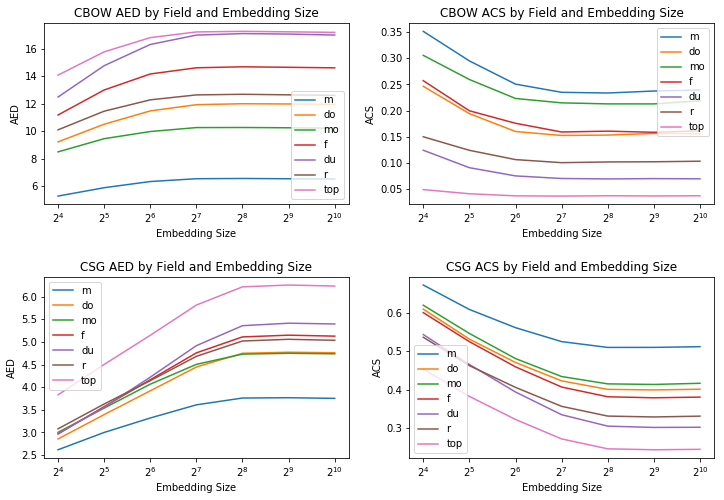

In [80]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(12, 8))
plt.subplots_adjust(hspace=0.4)
plt.subplot(222)
plt.semilogx(points, averages[0, :, 0, 1], label="m", basex=2)
plt.semilogx(points, averages[0, :, 1, 1], label="do", basex=2)
plt.semilogx(points, averages[0, :, 2, 1], label="mo", basex=2)
plt.semilogx(points, averages[0, :, 3, 1], label="f", basex=2)
plt.semilogx(points, averages[0, :, 4, 1], label="du", basex=2)
plt.semilogx(points, averages[0, :, 5, 1], label="r", basex=2)
plt.semilogx(points, averages[0, :, 6, 1], label="top", basex=2)
plt.title('CBOW ACS by Field and Embedding Size')
plt.xlabel("Embedding Size")
plt.ylabel("ACS")
plt.legend()

plt.subplot(221)
plt.semilogx(points, averages[0, :, 0, 0], label="m", basex=2)
plt.semilogx(points, averages[0, :, 1, 0], label="do", basex=2)
plt.semilogx(points, averages[0, :, 2, 0], label="mo", basex=2)
plt.semilogx(points, averages[0, :, 3, 0], label="f", basex=2)
plt.semilogx(points, averages[0, :, 4, 0], label="du", basex=2)
plt.semilogx(points, averages[0, :, 5, 0], label="r", basex=2)
plt.semilogx(points, averages[0, :, 6, 0], label="top", basex=2)
plt.title('CBOW AED by Field and Embedding Size')
plt.xlabel("Embedding Size")
plt.ylabel("AED")
plt.legend()

plt.subplot(224)
plt.semilogx(points, averages[1, :, 0, 1], label="m", basex=2)
plt.semilogx(points, averages[1, :, 1, 1], label="do", basex=2)
plt.semilogx(points, averages[1, :, 2, 1], label="mo", basex=2)
plt.semilogx(points, averages[1, :, 3, 1], label="f", basex=2)
plt.semilogx(points, averages[1, :, 4, 1], label="du", basex=2)
plt.semilogx(points, averages[1, :, 5, 1], label="r", basex=2)
plt.semilogx(points, averages[1, :, 6, 1], label="top", basex=2)
plt.title('CSG ACS by Field and Embedding Size')
plt.xlabel("Embedding Size")
plt.ylabel("ACS")
plt.legend()

plt.subplot(223)
plt.semilogx(points, averages[1, :, 0, 0], label="m", basex=2)
plt.semilogx(points, averages[1, :, 1, 0], label="do", basex=2)
plt.semilogx(points, averages[1, :, 2, 0], label="mo", basex=2)
plt.semilogx(points, averages[1, :, 3, 0], label="f", basex=2)
plt.semilogx(points, averages[1, :, 4, 0], label="du", basex=2)
plt.semilogx(points, averages[1, :, 5, 0], label="r", basex=2)
plt.semilogx(points, averages[1, :, 6, 0], label="top", basex=2)
plt.title('CSG AED by Field and Embedding Size')
plt.xlabel("Embedding Size")
plt.ylabel("AED")
plt.legend()
plt.show()

# Visualisation

In [61]:
fn.visualise(model, sentences, [target_dict['reasons']], 1000, 'Medications in top 1000 words')

# Naive Test 

In [60]:
for target in ['medications']:
    for reps in [True, False]:
        target_size = len(target_dict[target])
        word_sets = fn.generate_naive_traintest(vocab, target_dict[target], target_size * 5, target_size, 10, 50, reps, reps)
        emb_sets = fn.embed_words(word_sets, model)
        emb_sets['validation_set'] = emb_sets['test_set']
        emb_sets['validation_labels'] = emb_sets['test_labels']
        print("Target: {}\tRepetitions: {}".format(target, reps))
        NN = FF_Model()
        NN.build_graph()
        NN.train(emb_sets, epochs=50, report_percentage=10, show_progress=True)

Target: medications	Repetitions: True
FInal Values: Tr-F1: 0.8531, Val-F1: 0.8333
Test F1-Score: 0.8333

Target: medications	Repetitions: False
FInal Values: Tr-F1: 0.8305, Val-F1: 0.7714
Test F1-Score: 0.7677



# HyperParameter Scan

In [35]:
emb_model = {'CBOW': 0, 'CSG': 1}
NN_num = 10
emb_sizes = [16, 32, 64, 128, 256, 512, 1024]
layers = [[16], [32], [64], [128], [256], [512], [1024]]
layer_num = [1, 2, 3]
dropouts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
learn_rates = [0.0001, 0.001, 0.01, 0.1, 1]
epoch_nums = [2, 4, 8, 16, 32, 64, 128]

model_num = len(emb_model) * NN_num * len(emb_sizes) * len(layers) * len(dropouts) * \
            len(learn_rates) * len(epoch_nums)
target = target_dict['medications']

print(model_num)

377300


In [37]:
#emb_model = {'CBOW': 0, 'CSG': 1}
NN_num = 5
#emb_sizes = [64, 128, 256, 512]
layers = [[64], [128], [256], [512]]
layer_num = [1, 2, 3]
dropouts = [0.1, 0.3, 0.5, 0.7]
learn_rates = [0.001, 0.01, 0.1]
epoch_nums = [4, 16, 64, 128]

#model_num = len(emb_model) * NN_num * len(emb_sizes) * len(layers) * len(dropouts) * \
            len(learn_rates) * len(epoch_nums)

model_num = NN_num * len(layers) * len(dropouts) * len(learn_rates) * len(epoch_nums)

target = target_dict['medications']

print(model_num)

7680


In [ ]:
word_sets = fn.generate_naive_traintest(vocab=vocab,
                                        labels=target,
                                        train_size=10000,
                                        test_size=1000,
                                        train_label_percentage=10,
                                        test_label_percentage=10,
                                        word_repetition = True,
                                        label_repetition = True)

In [ ]:
#iterations = [emb_sizes, layers, layer_num, dropouts, learn_rates, epoch_nums]
iterations = [layers, layer_num, dropouts, learn_rates, epoch_nums]

In [ ]:
n = 0
parameters = []
results = []
timestamp = re.sub(r':', '-', str(datetime.datetime.now()).split('.')[0])

with open('tests/Model1/' + timestamp, 'w+') as f:
    print('EmbSz:\tLay:\tDrop:\tLeRa:\tEpochs:\tBatSz:\tF1:')
    f.write('EmbSz:\tLay:\tDrop:\tLeRa:\tEpochs:\tBatSz:\tF1:\n')
    for par in itertools.product(*iterations):
        best = 0
        parameters.append(par)
        for i in range(emb_num):
            model = Word2Vec(sentences, min_count=1, size=par[0])
            emb_sets = fn.embed_words(word_sets, model)
            emb_sets['validation_set'] = emb_sets['test_set']
            emb_sets['validation_labels'] = emb_sets['test_labels']
            for j in range(NN_num):
                n += 1
                print('Model Number: {}/{}'.format(n, model_num), end='\r')
                NN = FF_Model(input_size=par[0], layers=par[1], dropout=par[2], learn_rate=par[3])
                NN.build_graph()
                _, _, _, score = NN.train(emb_sets, epochs=par[4], batch=par[5], report_percentage=report_percentage)
                best = max(best, score)
        results.append(best)
        print('{}\t{}\t{}\t{}\t{}\t{}\t{:.4f}'.format(*parameters[-1], results[-1]))
        f.write('{}\t{}\t{}\t{}\t{}\t{}\t{:.4f}\n'.format(*parameters[-1], results[-1]))

    print('Max Performance: {:.4f}'.format(max(results)))  
    f.write('Max Performance: {:.4f}\n'.format(max(results)))